In [1]:
import json
import os
from sympy import symbols, simplify, sin, expand
#from pysr import PySRRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

/home/paolo/.conda/envs/pymc_env/lib/python3.12/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
import pymc as pm
import arviz as az

In [3]:
x = np.linspace(-2, 2, 500)
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
noise = rng.normal(size=x.shape, scale = 0.05)
y = np.cos(x) + noise 

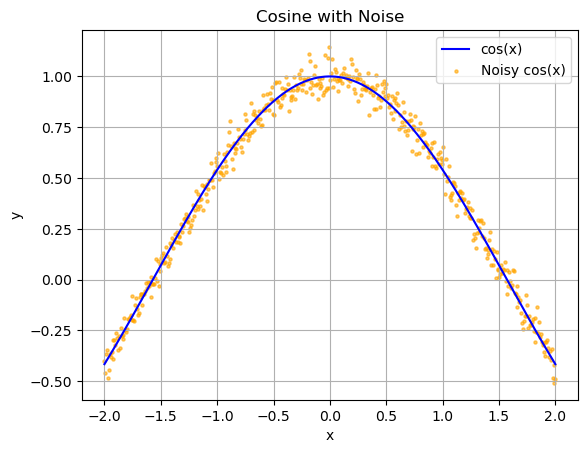

In [4]:
plt.plot(x, np.cos(x), label='cos(x)', color='blue')
plt.scatter(x, y, s=5, alpha=0.6, label='Noisy cos(x)', color='orange')
plt.legend()
plt.title('Cosine with Noise')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [5]:
# # Save to CSV in a format SISSO++ expects
# df = pd.DataFrame({"sample_id": [f"s{i+1}" for i in range(len(x))], 'f1': x, 'target': y})
# df.to_csv("/home/paolo/Thesis/Test_uncertainty/data/cosine_data.csv", index=False)
# data_file = "/home/paolo/Thesis/Test_uncertainty/data/cosine_data.csv"

# os.environ["SISSOPP_TUT_DAT_FILE"] = data_file

In [6]:
# # Try the fit with the exact functional form
# cos_json = {
#     'data_file': data_file,
#      'property_key': 'target',
#      'desc_dim': 1,
#      'n_sis_select': 10,
#      'max_rung': 2,
#      'calc_type': 'regression',
#      'min_abs_feat_val': 1e-05,
#      'max_abs_feat_val': 1e8,
#      'n_residual': 10,
#      'n_models_store': 10,
#      'leave_out_frac': 0.0,
#      'leave_out_inds': [],
#      'opset': ['add', 'sub', 'mult', 'div', 'cos', 'sin', 'sqrt', 'sq']
# }
# json.dump(cos_json, open("/home/paolo/Thesis/Test_uncertainty/data/cos.json", "w"), indent=4)

In [7]:
# # Try the fit with the exact functional form
# cos_json = {
#     'data_file': data_file,
#      'property_key': 'target',
#      'desc_dim': 1,
#      'n_sis_select': 10,
#      'max_rung': 2,
#      'calc_type': 'regression',
#      'min_abs_feat_val': 1e-05,
#      'max_abs_feat_val': 1e8,
#      'n_residual': 10,
#      'n_models_store': 10,
#      'leave_out_frac': 0.0,
#      'leave_out_inds': [],
#      'opset': ['add', 'sub', 'mult', 'div', 'cos', 'sin', 'sqrt', 'sq']
# }
# json.dump(cos_json, open("/home/paolo/Thesis/Test_uncertainty/data/cos.json", "w"), indent=4)

In [8]:
# Extract the formulas and the values of the parameters from the SISSO output
formulas = []
a0_list = []
c0_list = []
models_stored = 10
for i in range(models_stored):
    filename = f'./models_cosine/train_dim_1_model_{i}.dat'
    with open(filename, 'r') as f:
        line1 = next(f)               # First line
        for _ in range(4): next(f)    # Skip lines 2 to 5
        line6 = next(f)               # Sixth line
        formula = line1.replace('#', '').strip()
        # Split line6 by spaces
        parts = line6.strip().split()
        a0_i = parts[3].rstrip(',')
        c0_i = parts[4].rstrip(',')

        formulas.append(formula)
        a0_list.append(a0_i)
        c0_list.append(c0_i)
        print(formula, a0_i, c0_i)

c0 + a0 * cos(f1) 1.001325831302119e+00 -1.256782741748731e-03
c0 + a0 * (sin(f1) / f1) 2.660682304939602e+00 -1.681643326882762e+00
c0 + a0 * (cos(f1) - (f1^2)) 2.717475659877717e-01 6.929549500655449e-01
c0 + a0 * (f1^2) -3.720431943703498e-01 9.502941844118713e-01
c0 + a0 * (sin(f1) * f1) -6.966557323989504e-01 1.060213819741886e+00
c0 + a0 * (cos(f1) + (f1^2)) -5.869170069366709e-01 1.503758358056813e+00
c0 + a0 * cos((f1^2)) 5.695328649434339e-01 3.218424044159163e-01
c0 + a0 * ((f1^2)^2) -9.636360803755634e-02 7.630870787141347e-01
c0 + a0 * (sin(f1)^2) -1.108088324828590e+00 1.111630451799396e+00
c0 + a0 * (sin(f1) - (f1^2)) 2.633141470454703e-01 8.047410709589261e-01


In [9]:
# Store the numerical values of the parameters into np arrays
a0 = np.array(a0_list, dtype=float)
c0 = np.array(c0_list, dtype=float)
a0, c0

(array([ 1.00132583,  2.6606823 ,  0.27174757, -0.37204319, -0.69665573,
        -0.58691701,  0.56953286, -0.09636361, -1.10808832,  0.26331415]),
 array([-1.25678274e-03, -1.68164333e+00,  6.92954950e-01,  9.50294184e-01,
         1.06021382e+00,  1.50375836e+00,  3.21842404e-01,  7.63087079e-01,
         1.11163045e+00,  8.04741071e-01]))

In [10]:
a0_simb, c0_simb, x_simb = sp.symbols('a0 c0 f1')
symbol_map = {'x': x_simb, 'a0': a0_simb, 'c0': c0_simb}

# Converts the equtions (stored into the 'Feature Expression' column of df) from strings into sympy objects
sympy_exprs = [sp.sympify(f, locals=symbol_map) for f in formulas]
# Builds Python functions starting from the sympy expressions pruning the constants
functions = [sp.lambdify((x_simb), (expr - c0_simb)/a0_simb, modules='numpy') for expr in sympy_exprs]

In [11]:
sympy_exprs

[a0*cos(f1) + c0,
 a0*sin(f1)/f1 + c0,
 a0*(-f1**2 + cos(f1)) + c0,
 a0*f1**2 + c0,
 a0*f1*sin(f1) + c0,
 a0*(f1**2 + cos(f1)) + c0,
 a0*cos(f1**2) + c0,
 a0*f1**4 + c0,
 a0*sin(f1)**2 + c0,
 a0*(-f1**2 + sin(f1)) + c0]

In [12]:
for expr in sympy_exprs:
    print(sp.simplify((expr - c0_simb)/a0_simb))

cos(f1)
sin(f1)/f1
-f1**2 + cos(f1)
f1**2
f1*sin(f1)
f1**2 + cos(f1)
cos(f1**2)
f1**4
sin(f1)**2
-f1**2 + sin(f1)


In [13]:
# In each column are stacked data for each of the 10 different formulas
Phi = np.column_stack([f(x) for f in functions])
n_features = Phi[:,0].shape
n_features

(500,)

In [14]:
# basic_model = pm.Model()

# with basic_model:
#     # Priors for unknown model parameters
#     # Normal weights
#     alpha = pm.Normal("c0", mu=c0[3], sigma=10)
#     beta = pm.Normal("a0", mu=a0[3], sigma=10)
#     # Sigma is positively defined and normally distributed --> HalfNormal
#     sigma = pm.HalfNormal("sigma", sigma=1)

#     # Expected value of outcome, Linear model
#     mu = alpha + beta * Phi[:, 3]

#     # Likelihood (sampling distribution) of observations --> normal distribution with the deterministic equation as mean and sigma as variance
#     y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
#     # draws 2000 posterior samples from the unnormalized posterior distribution computed as likelihood x prior using sequential montecarlo method
#     idata = pm.smc.sample_smc()
#     # idata = pm.sample()

In [15]:
traces = []
for i in range(models_stored):
    with pm.Model() as model:
        # Select the i-th column
        f = Phi[:, i]

        # Priors, Che valori di sigma potrei usare? 10 forse è un po' troppo
        c0_coeff = pm.Normal("c0", mu=c0[i], sigma=10)
        a0_coeff = pm.Normal("a0", mu=a0[i], sigma=10)
        sigma = pm.HalfNormal("sigma", sigma=2)

        # Linear parametrization
        mu = c0_coeff + a0_coeff * f

        # Likelihood
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

        # Sample from posterior
        # Sequential montecarlo chiedi spiegazione
        trace = pm.smc.sample_smc()
        #trace = pm.sample()
        traces.append(trace)

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

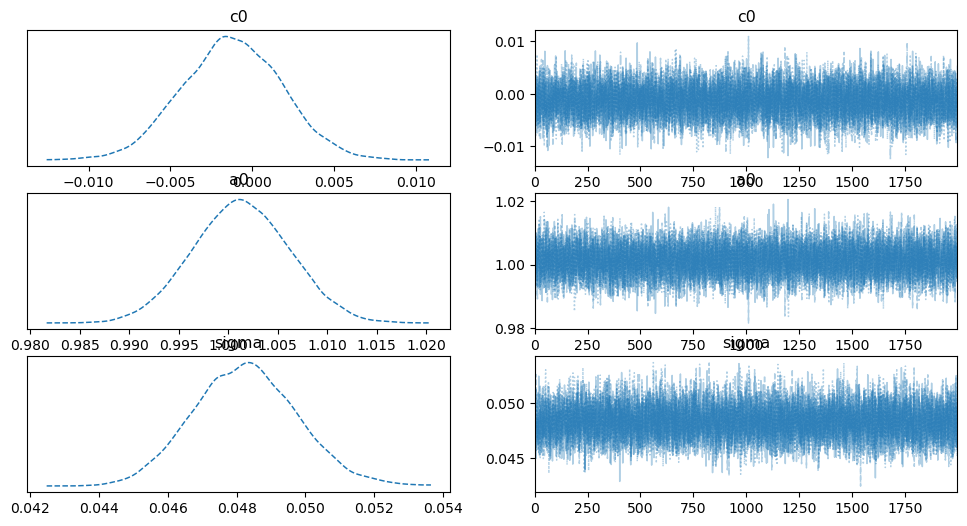

In [16]:
az.plot_trace(traces[0], combined=True);

In [17]:
az.summary(traces[0], round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,-0.001,0.003,-0.007,0.005,0.0,0.0,12175.208,11975.357,1.000
a0,1.001,0.005,0.992,1.011,0.0,0.0,11862.473,11520.662,1.001
sigma,0.048,0.002,0.045,0.051,0.0,0.0,8194.180,10112.881,1.007


In [18]:
c0[0], a0[0]

(np.float64(-0.001256782741748731), np.float64(1.001325831302119))

We have used Sequential MonteCarlo as a sampling technique since it is able to provide us a robust estimate of the evidence, also called marginal likelihood.
In Bayes' formula:
$$
    p(\theta | D) = \frac{p(D|\theta) \ p(\theta)}{p(D)}
$$
where the evidence is defined as $p(D) = \int d\theta \ p(d|\theta) p(\theta)$, obtained marginalizing the likelihood thus the name.

Actually for numerical reasons the returned value is the log marginal likelihood (this helps to avoid underflow), we thus need to exponentiate to get the marginal likelihood.

In [19]:
traces[i].sample_stats["log_marginal_likelihood"]

<xarray.DataArray 'log_marginal_likelihood' (chain: 1, draw: 6)> Size: 48B
array([[list([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(-36.193205996279524)]),
        list([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(-36.63826534535717)]),
        list([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(-35.23782599979562)]),
        list([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(-33.69486422725357)]),
        list([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(-35.95222187804596)]),
        list([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(-37.658748635662555)])]],
      dtype=object)
Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 48B 0 1 2 3 4 5

In [20]:
# log marginal likelihood for model 0: 6 chains and 11 draws per chain
traces[1].sample_stats["log_marginal_likelihood"].values 

array([[list([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(741.3820931716313)]),
        list([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(743.6519508034322)]),
        list([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(740.3333485924211)]),
        list([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(737.9707460213331)]),
        list([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(730.5552889524122)]),
        list([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(750.436871363195)])]],
      dtype=object)

In [21]:
traces[0].sample_stats["log_marginal_likelihood"].values 

array([[list([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(764.9563164228528)]),
        list([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(783.0941837854685)]),
        list([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(782.5000166905884)]),
        list([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(774.2887177574896)]),
        list([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(776.6908541407432)]),
        list([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(777.402950264447)])]],
      dtype=object)

In [22]:
marginal_likelihoods = []
log_marginal_likelihoods = []
for i in range(models_stored):
    log_ml_raw = traces[i].sample_stats["log_marginal_likelihood"].values
    # Flatten possible nested lists and cast to floats
    flattened = []
    for row in log_ml_raw.ravel():
        # If it’s a list, tuple, or NumPy array then flattened.extend(row) appends all items inside it (not the list itself).
        if isinstance(row, (list, tuple, np.ndarray)):
            flattened.extend(row)
        # Otherwise (a plain number or NaN) then flattened.append(row) just adds the single value.
        else:
            flattened.append(row)
    #print(flattened)
    # This ensures that everything inside flattened is a single scalar number, not a list or array.
    log_ml = np.array(flattened, dtype=float)
    # Checks that the entry is effectively a number
    log_ml = log_ml[~np.isnan(log_ml)]
    print(log_ml)
    # Computes the mean
    mean_log_ml = np.mean(log_ml)
    log_marginal_likelihoods.append(mean_log_ml)

[764.95631642 783.09418379 782.50001669 774.28871776 776.69085414
 777.40295026]
[741.38209317 743.6519508  740.33334859 737.97074602 730.55528895
 750.43687136]
[684.63488582 689.29674406 684.73749485 665.50201486 657.47809525
 648.5814023 ]
[635.87808144 625.18343248 624.54678502 623.45583922 625.9875121
 623.90604017]
[513.66390624 514.70123986 521.54456132 512.47971802 512.41550243
 516.54074615]
[498.29791039 497.54924902 502.54220658 496.90455996 500.1914064
 497.96104159]
[376.12082428 378.05958439 379.73304683 383.80490523 375.65345792
 372.43186002]
[134.65350993 134.2828519  132.19814606 133.78846269 134.52950369
 138.21366373]
[66.44386277 65.59185495 68.48130841 67.3297296  67.3061917  69.47911764]
[-36.193206   -36.63826535 -35.237826   -33.69486423 -35.95222188
 -37.65874864]


In [23]:
log_marginal_likelihoods

[np.float64(776.4888398435983),
 np.float64(740.7217164840708),
 np.float64(671.7051061906614),
 np.float64(626.4929484036583),
 np.float64(515.2242790028059),
 np.float64(498.907728990199),
 np.float64(377.6339464431193),
 np.float64(134.61102299957244),
 np.float64(67.4386775089602),
 np.float64(-35.89585534706574)]

In [24]:
# Recovers the highest ml value and its related index, i.e. model
max_ml = np.max(log_marginal_likelihoods)
argmax_ml = np.argmax(log_marginal_likelihoods)
max_ml, argmax_ml 

(np.float64(776.4888398435983), np.int64(0))

We have found the equation with the highest marginal likelihood (for $\beta = 1$) and we are going to use it as a benchmark to gauge the quality of the other models, i.e. how "badly" do they perform against the benchmark.

In [25]:
# Computes the marginal likelihood ratios between the given model and the benchmark
ml_diff = []
for i in range(models_stored):
    ml_diff.append(np.exp(-(log_marginal_likelihoods[argmax_ml] - log_marginal_likelihoods[i])))
ml_diff

[np.float64(1.0),
 np.float64(2.9277614722269587e-16),
 np.float64(3.1117355487249946e-46),
 np.float64(7.204635927691509e-66),
 np.float64(3.421707722554042e-114),
 np.float64(2.805790728467343e-121),
 np.float64(6.018949729036636e-174),
 np.float64(1.7218927146615767e-279),
 np.float64(1.15724977618638e-308),
 np.float64(0.0)]

In [26]:
np.argsort(ml_diff)

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

# Tempering

In [31]:
# beta = np.arange(0, 1.1, 0.2)
beta = np.array([1/8, 1/4, 1/2,  1])
beta

array([0.125, 0.25 , 0.5  , 1.   ])

In [32]:
traces_temp = []
for i in range(models_stored):
    traces_i = []
    for j in beta.round(2):
        with pm.Model() as model:
            # Select the i-th column
            f = Phi[:, i]
    
            # Priors
            c0_coeff = pm.Normal("c0", mu=c0[i], sigma=10)
            a0_coeff = pm.Normal("a0", mu=a0[i], sigma=10)
            sigma = pm.HalfNormal("sigma", sigma=2)
    
            # Linear parametrization
            mu = c0_coeff + a0_coeff * f
    
            # Standard log-likelihood
            dist = pm.Normal.dist(mu=mu, sigma=sigma)
            logp = pm.logp(dist, y)

            # Tempered likelihood --> log (y| theta) = sum_n log(y_n|theta)
            pm.Potential("tempered_likelihood", j * logp.sum())
    
            # Sample from posterior
            # Sequential montecarlo
            trace = pm.smc.sample_smc(draws=2000, threshold=0.3)
            #trace = pm.sample()
            traces_i.append(trace)
    traces_temp.append(traces_i)

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

In [33]:
traces_temp[0][1].sample_stats["log_marginal_likelihood"].values

array([[list([nan, nan, nan, nan, nan, nan, nan, nan, np.float64(168.77335658726076)]),
        list([nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(166.0353851319187)]),
        list([nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(159.10540930541185)]),
        list([nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(162.03850772155144)]),
        list([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(156.17789351471168)]),
        list([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(129.22772594861917)])]],
      dtype=object)

In [34]:
marginal_likelihoods_temp = []
log_marginal_likelihoods_temp = []
for i in range(models_stored):
    for j in range(len(beta)):
        log_ml_raw = traces_temp[i][j].sample_stats["log_marginal_likelihood"].values
    
        # Flatten possible nested lists and cast to floats
        flattened = []
        for row in log_ml_raw.ravel():
            # If it’s a list, tuple, or NumPy array then flattened.extend(row) appends all items inside it (not the list itself).
            if isinstance(row, (list, tuple, np.ndarray)):
                flattened.extend(row)
            # Otherwise (a plain number or NaN) then flattened.append(row) just adds the single value.
            else:
                flattened.append(row)
        # This ensures that everything inside flattened is a single scalar number, not a list or array.
        log_ml_temp = np.array(flattened, dtype=float)
        # Checks that the entry is effectively a number
        log_ml_temp = log_ml_temp[~np.isnan(log_ml_temp)]
        print(log_ml_temp)
        # Computes the mean
        mean_log_ml_temp = np.mean(log_ml_temp)
        log_marginal_likelihoods_temp.append(mean_log_ml_temp)

[70.81296029 62.37283237 68.04264471 59.23004535 41.19554567 77.94116389]
[168.77335659 166.03538513 159.10540931 162.03850772 156.17789351
 129.22772595]
[380.01333099 377.78953097 372.39912702 363.80826938 369.35617131
 374.44047767]
[782.94602212 783.51832064 777.35576192 772.66258012 748.6488641
 748.53537495]
[70.44992911 59.71929381 68.21494329 73.31856507 67.82535564 68.17502612]
[169.91764632 169.97467122 159.02662115 159.19779001 167.67885941
 163.55206496]
[355.84766609 345.29855707 357.88061284 346.21239875 347.92269173
 360.60054371]
[734.84130006 749.44466407 738.34360679 732.41448791 726.79122123
 746.45342016]
[57.50124591 41.42211437 41.86572906 52.12712235 50.58179623 42.93854397]
[146.29842389 129.97515719 130.60751226 124.82396039 136.75337865
 132.43660184]
[320.90716087 322.75807582 317.28499425 318.8339882  333.44888202
 306.31942761]
[674.02804484 665.327535   670.54478204 647.82467614 547.89238736
 571.28566878]
[47.52747628 58.09564779 59.16228858 42.84993583 5

In [35]:
log_marginal_likelihoods_temp = np.array(log_marginal_likelihoods_temp).reshape(models_stored, len(beta))

In [36]:
log_marginal_likelihoods_temp # dim = (models_select=10, len(beta) = 4)

array([[ 63.26586538, 156.89304637, 372.96781789, 768.94448731],
       [ 67.95051884, 164.89127551, 352.29374503, 738.0481167 ],
       [ 47.73942531, 133.4825057 , 319.92542146, 629.48384903],
       [ 48.08576666, 118.30452044, 278.87344135, 625.22699994],
       [ 37.73952925, 109.02158326, 237.11090742, 512.59491805],
       [ 38.30245654, 103.30065119, 233.46194859, 500.44367247],
       [ 20.26943576,  78.39353092, 172.62141935, 373.44072888],
       [ -3.71924112,  16.39625589,  51.61078619, 130.51203628],
       [ -5.80210842,   3.67124957,  24.97623131,  67.85413193],
       [-19.2664084 , -23.54328928, -26.74056004, -34.66962758]])

In [38]:
log_marginal_likelihoods, log_marginal_likelihoods_temp.T[3]

([np.float64(776.4888398435983),
  np.float64(740.7217164840708),
  np.float64(671.7051061906614),
  np.float64(626.4929484036583),
  np.float64(515.2242790028059),
  np.float64(498.907728990199),
  np.float64(377.6339464431193),
  np.float64(134.61102299957244),
  np.float64(67.4386775089602),
  np.float64(-35.89585534706574)],
 array([768.94448731, 738.0481167 , 629.48384903, 625.22699994,
        512.59491805, 500.44367247, 373.44072888, 130.51203628,
         67.85413193, -34.66962758]))

In [ ]:
ml_diff

In [39]:
# For each value of beta (comlumn) finds the representative with the highest marginal likelihood
for j in range(len(beta)):
    print(np.argmax(log_marginal_likelihoods_temp[:,j]))

1
1
0
0


In [40]:
ml_diff_temp = []
for i in range(models_stored):
    for j in range(len(beta)):
        # log_marginal_likelihoods_temp[np.argmax(marginal_likelihoods_temp[:,j]), j] --> log_marg_likelihood of the benchmark for that value of beta
        # e.g. if j=1 --> np.argmax(marginal_likelihoods_temp[:,j]) = (1,1) --> log_marginal_likelihoods_temp[1, 1]
        ml_diff_temp.append(np.exp(-(log_marginal_likelihoods_temp[np.argmax(log_marginal_likelihoods_temp[:,j]), j] - log_marginal_likelihoods_temp[i,j])))

In [41]:
ml_diff_temp = np.array(ml_diff_temp).reshape(models_stored, len(beta))
ml_diff_temp.T # Each row corresponds to the ml difference computed with the same value of beta for the different models

array([[9.23593467e-003, 1.00000000e+000, 1.66891266e-009,
        2.35965083e-009, 7.57763929e-014, 1.33048550e-013,
        1.96050850e-021, 7.48546407e-032, 9.32483070e-033,
        1.32485933e-038],
       [3.36057211e-004, 1.00000000e+000, 2.28741302e-014,
        5.85638131e-021, 5.44629235e-025, 1.78456232e-027,
        2.71961124e-038, 3.23171005e-065, 9.61683937e-071,
        1.45850632e-082],
       [1.00000000e+000, 1.05042304e-009, 9.20407020e-024,
        1.36562509e-041, 9.95619639e-060, 2.59042348e-061,
        9.78733930e-088, 2.73158306e-140, 7.39901993e-152,
        2.56364032e-174],
       [1.00000000e+000, 3.81835879e-014, 2.71028120e-061,
        3.83962032e-063, 4.66440907e-112, 2.46364273e-117,
        1.71751343e-172, 5.39895180e-278, 3.31380800e-305,
        0.00000000e+000]])

In [42]:
# Indices corresponding to the entries sorted in ascending order 
np.argsort(ml_diff_temp.T)

array([[9, 8, 7, 6, 4, 5, 2, 3, 0, 1],
       [9, 8, 7, 6, 5, 4, 3, 2, 0, 1],
       [9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
       [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]])

The top scoring equations seem to retain their classification for different values of beta, i.e. for different weights of the likelihood.

# Calibration

In [ ]:
traces[0].posterior['c0'].mean().values

In [ ]:
Phi.shape

In [ ]:
# y_mean = []
# for m in range(models_stored):
#     # Computes y with the posterior mean values of the parameters c0, a0 and sigma_0
#     y_mean.append(traces[m].posterior['c0'].mean().values + traces[m].posterior['a0'].mean().values * Phi[:, m])
# # Stores the values of c0_post_mean + a0_post_mean * Phi, shape (500, 10) each column stores a different model
# y_mean = np.array(y_mean).T
# y_mean.shape

In [ ]:
np.random.seed(10)
c0_samples_list = []
a0_samples_list = []
sigma_samples_list = []
for m in range(models_stored):
# Draws 50 samples of the parameters from the posterior distribution
    c0_samples_list.append(np.random.choice(traces[m].posterior['c0'].values.flatten(), size=200, replace=True))
    a0_samples_list.append(np.random.choice(traces[m].posterior['a0'].values.flatten(), size=200, replace=True))
    sigma_samples_list.append(np.random.choice(traces[m].posterior['sigma'].values.flatten(), size=200, replace=True))
c0_samples = np.array(c0_samples_list).T
a0_samples = np.array(a0_samples_list).T
sigma_samples = np.array(sigma_samples_list).T

In [ ]:
c0_samples.shape

In [ ]:
plt.hist(np.array(c0_samples.T[0]), alpha = 0.5, bins = 20, density = True)
plt.hist(traces[0].posterior['c0'].values.flatten(), bins = 100, alpha = 0.5, density = True)
plt.show()

In [ ]:
c0_samples.shape, a0_samples.shape, sigma_samples.shape

In [ ]:
inputs = 500
y_emp = np.zeros((inputs, models_stored))
for i in range(inputs):
    for m in range(models_stored):
        # Computes the mean over the ensemble for each of the 500 points for each of the 10 formulas
        y_emp[i, m] = np.mean(c0_samples[:,m] + Phi[i, m] * a0_samples[:,m])
# Empirical mean over the models
y_emp

In [ ]:
y_emp.shape 

In [ ]:
inputs = 500
var_emp = np.zeros((inputs, models_stored))
for i in range(inputs):
    for m in range(models_stored):
        # Computes the variance over the ensemble for each of the 500 points for each of the 10 formulas
        #var_emp[i, m] = np.var((c0_samples + Phi[i, m] * a0_samples + sigma_samples - y_emp[i,m])**2), ddof = 1)
        # Assuming decorrelation between noise and parameters
        var_emp[i, m] = 1/(200-1) * np.sum((c0_samples[:,m] + Phi[i, m] * a0_samples[:,m] - y_emp[i,m])**2 + sigma_samples[:,m]**2)
# Empirical variance over the models
var_emp

In [ ]:
for i in range(models_stored):
    plt.plot(x, var_emp[:, i], label=fr'{sympy_exprs[i]}')
plt.legend()
plt.title('Cosine with noise', fontsize=14)
plt.xlabel('Input points', fontsize=12)
plt.ylabel('Empirical Variance', fontsize=12)
plt.show()

In [ ]:
var_emp.shape #500

In [ ]:
y_obs = np.tile(y, (10,1)).T
y_obs

In [ ]:
# Columnwise mean of the given vector, i.e. mean over the features
R = np.mean((y_obs - y_emp)**2/var_emp, axis = 0)
R

$$
    R = \frac{1}{n_{features}} \sum_i^{n_{features}}\frac{ (y_i - \bar{y}_i)^2}{\sigma_i^2}
$$

If $R>1$ the system is overconfident otherwise if $R<1$ the system is underconfident.

In [ ]:
std = np.sqrt(var_emp)
plt.scatter(x, y, s=5, alpha=0.6, label='Noisy cos(x)', color='red')
plt.plot(x, y_emp[:,0], label='cos(x)', color='blue')
plt.fill_between(x, y_emp[:,0] - std[:,0], y_emp[:,0] + std[:, 0], color='blue', alpha=0.2)
l = 8
plt.plot(x, y_emp[:,l], label=fr'{sympy_exprs[l]}', color='g')
plt.fill_between(x, y_emp[:,l] - std[:,l], y_emp[:,l] + std[:, l], color='g', alpha=0.2)
plt.legend()
plt.xlabel('Input points', fontsize=12)
plt.ylabel('SISSO Functions', fontsize=12)
#plt.title('Cosine with noise', fontsize=14)
#plt.savefig('cosine.pdf', bbox_inches='tight', dpi=600)
#plt.tick_params(axis='both', labelsize=12)
plt.show()